<a href="https://colab.research.google.com/github/arunbretlee/demand-forecasting-for-inventory-optimization/blob/main/demand_forecasting_for_inventory_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid XGBoost + LSTM Demand Forecasting

This project implements a **hybrid time-series model using XGBoost and LSTM (PyTorch)** to forecast **weekly product demand**. The goal is to **reduce stockouts by 25%** and **optimize inventory planning** using machine learning and deep learning techniques.

---

## 📦 Project Structure

```
# This is formatted as code
```




---

## 🚀 Objectives

- Predict weekly demand for products using historical data
- Minimize stockouts by accurate forecasting
- Enable dynamic inventory optimization decisions

---

## 🧰 Tools & Technologies

- **Python**
- **XGBoost**
- **PyTorch**
- **pandas**, **NumPy**, **Matplotlib**
- **scikit-learn** for preprocessing

---

## 🧪 How It Works

### 1. Data Preprocessing
- Lag features, rolling averages, and date parts are engineered.
- Data is normalized and split into training and test sets.

### 2. XGBoost Model
- Learns non-linear feature relationships.
- Predictions from XGBoost are added as inputs to the LSTM.

### 3. LSTM Model
- Captures sequential dependencies in the demand data.
- Trained using PyTorch on sequences of `[xgb_prediction, actual_demand]`.

### 4. Forecasting
- Final predictions are inverse-transformed and plotted.
- These forecasts can be used to set reorder points or optimize stock levels.

---

## 📊 Output

The model outputs:
- Weekly demand forecast plot (predicted vs actual)
- Metrics: MAPE, RMSE (extendable)
- Inventory optimization recommendations (e.g., reorder week flags)

---

## 💡 Example Use Cases

- Inventory planning for retail chains
- Seasonal product restocking
- Dynamic reorder point adjustment

---

## ⚙️ Installation

```bash
git clone https://github.com/your-username/hybrid-demand-forecasting.git
cd hybrid-demand-forecasting
pip install -r requirements.txt


### **1. Setup and Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import xgboost as xgb


### **2. Sample Data Preparation**

In [ ]:
# Example data (replace with real dataset)
# df = pd.read_csv("weekly_demand.csv", parse_dates=["date"])
df = pd.DataFrame({
    "date": pd.date_range(start="2021-01-01", periods=104, freq='W'),
    "demand": np.random.poisson(lam=100, size=104)
})

df.set_index("date", inplace=True)
df["week"] = df.index.isocalendar().week
df["year"] = df.index.isocalendar().year


### **3. Feature Engineering for XGBoost**

In [ ]:
# Lag features
for lag in range(1, 5):
    df[f"lag_{lag}"] = df["demand"].shift(lag)

# Rolling average
df["rolling_mean_3"] = df["demand"].rolling(window=3).mean()

df.dropna(inplace=True)


### **4. Train XGBoost Model**

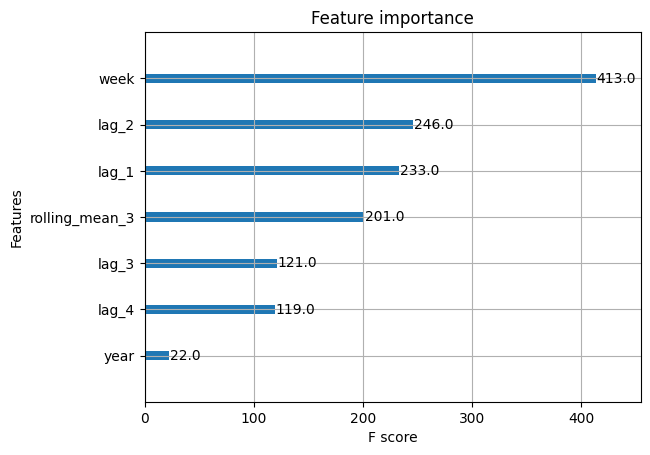

In [ ]:
X = df.drop(columns=["demand"])
y = df["demand"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Feature importance (optional)
xgb.plot_importance(xgb_model)
plt.show()

# Add predictions as feature for LSTM
df.loc[X_test.index, "xgb_pred"] = xgb_model.predict(X_test)


### **5. Prepare Sequence Data for LSTM**

In [ ]:
sequence_length = 4
features = ["xgb_pred", "demand"]

# Normalize
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features].dropna())
scaled_df = pd.DataFrame(scaled, columns=features, index=df.dropna().index)

# Sequence creation
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len][1]  # 'demand' is at index 1
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_data = scaled_df.values
X_seq, y_seq = create_sequences(seq_data, sequence_length)

# Split into train/test
train_size = int(len(X_seq) * 0.8)
X_train_seq = torch.tensor(X_seq[:train_size], dtype=torch.float32)
y_train_seq = torch.tensor(y_seq[:train_size], dtype=torch.float32).view(-1, 1)
X_test_seq = torch.tensor(X_seq[train_size:], dtype=torch.float32)
y_test_seq = torch.tensor(y_seq[train_size:], dtype=torch.float32).view(-1, 1)


### **6. Define and Train LSTM Model**

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

model = LSTMNet(input_size=2, hidden_size=64, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    model.train()
    output = model(X_train_seq)
    loss = criterion(output, y_train_seq)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.2693
Epoch 10, Loss: 1.2355
Epoch 20, Loss: 1.2055
Epoch 30, Loss: 1.1627
Epoch 40, Loss: 1.0940
Epoch 50, Loss: 0.9987
Epoch 60, Loss: 0.8801
Epoch 70, Loss: 0.7039
Epoch 80, Loss: 0.5438
Epoch 90, Loss: 0.4554


### **7. Evaluation**

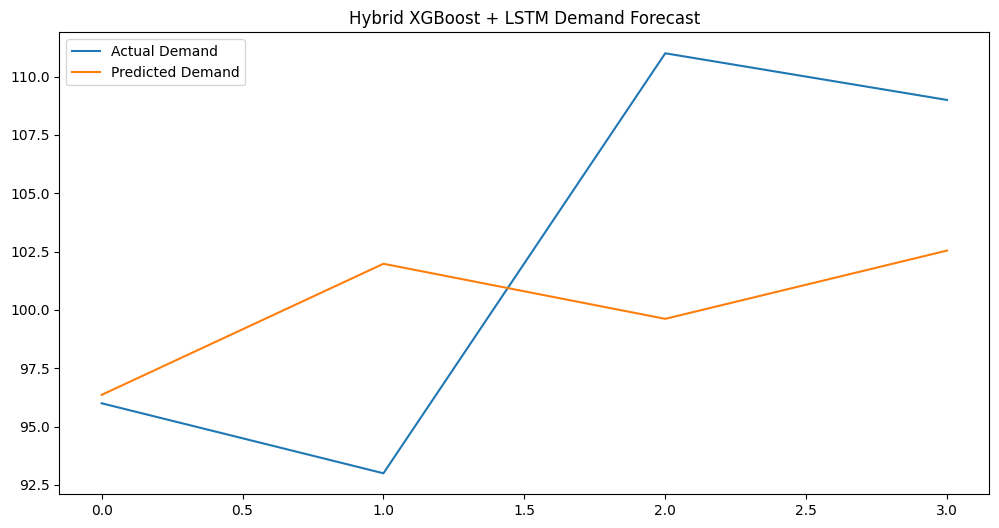

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_seq).numpy()

# Inverse scaling for evaluation
pred_demand = scaler.inverse_transform(np.hstack([X_test_seq[:, -1, 0].numpy().reshape(-1, 1), predictions]))[:, 1]
true_demand = scaler.inverse_transform(np.hstack([X_test_seq[:, -1, 0].numpy().reshape(-1, 1), y_test_seq.numpy()]))[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(true_demand, label="Actual Demand")
plt.plot(pred_demand, label="Predicted Demand")
plt.legend()
plt.title("Hybrid XGBoost + LSTM Demand Forecast")
plt.show()
